In [2]:
# Import Necessary Packages
import pandas_datareader.data as web
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\moumi\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Stocks
AMZN-AMAZON, WMT-WALMART, AAPL-APPLE, NFLX-NET FLIX

In [3]:
stocks = ['AMZN','WMT','AAPL','NFLX']
data = web.DataReader(stocks,data_source='yahoo',start='06/07/2020')['Adj Close']
#download daily price data for each of the stocks in the portfolio
table = web.DataReader(stocks,data_source='yahoo',start='06/07/2020')['Adj Close']

Text(0, 0.5, 'price in $')

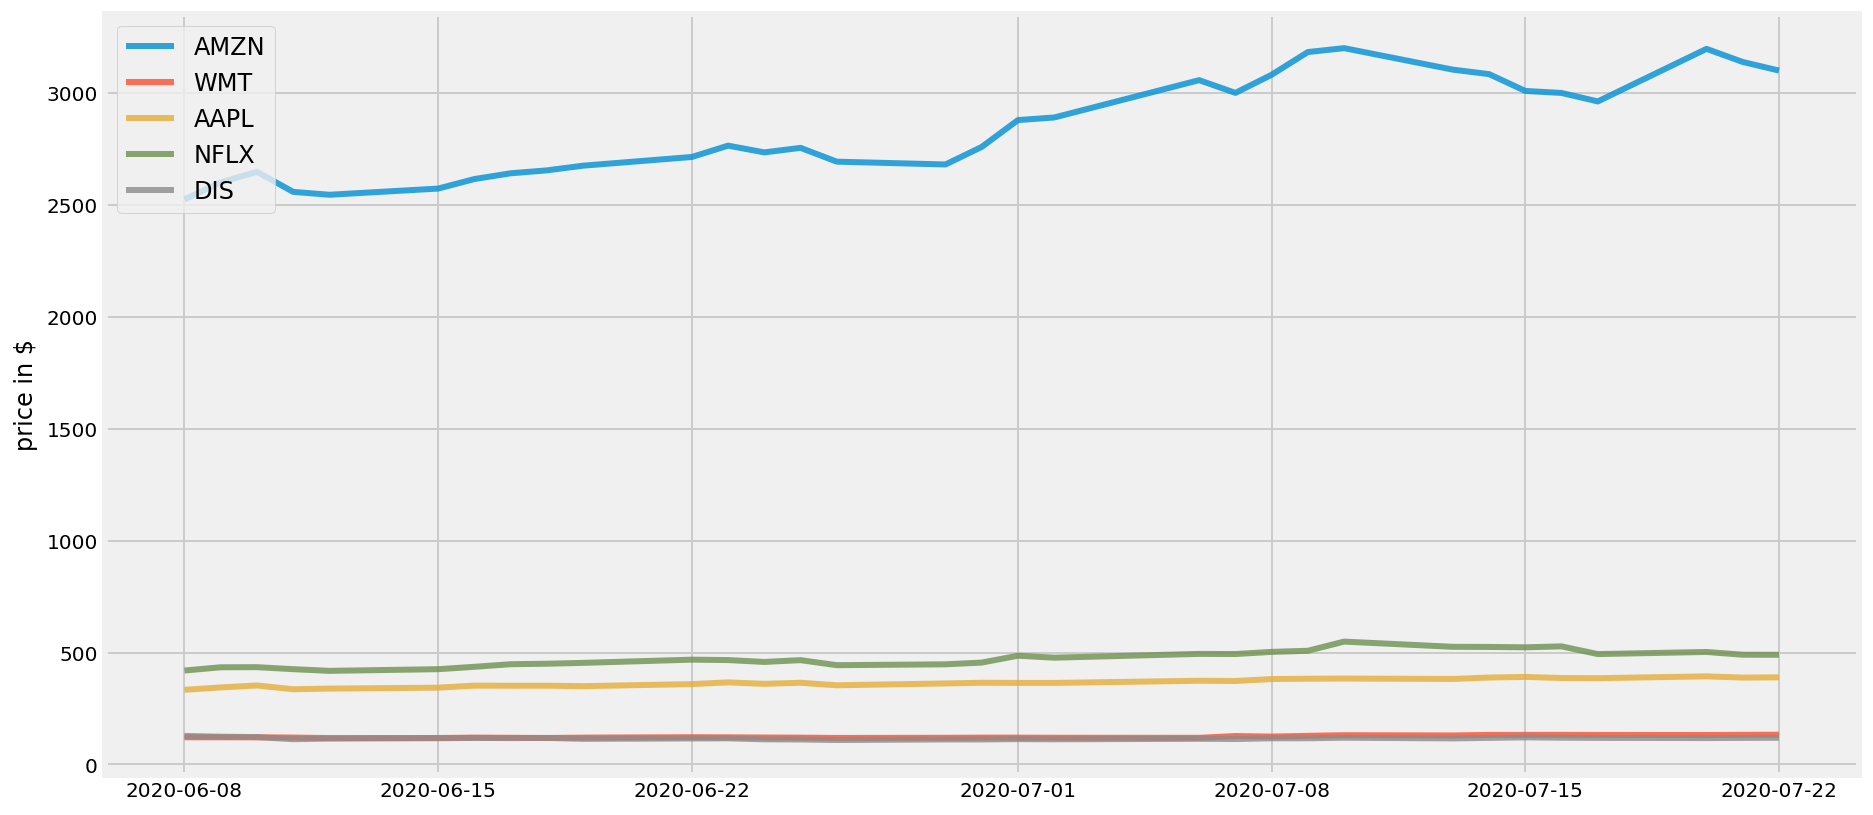

In [4]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

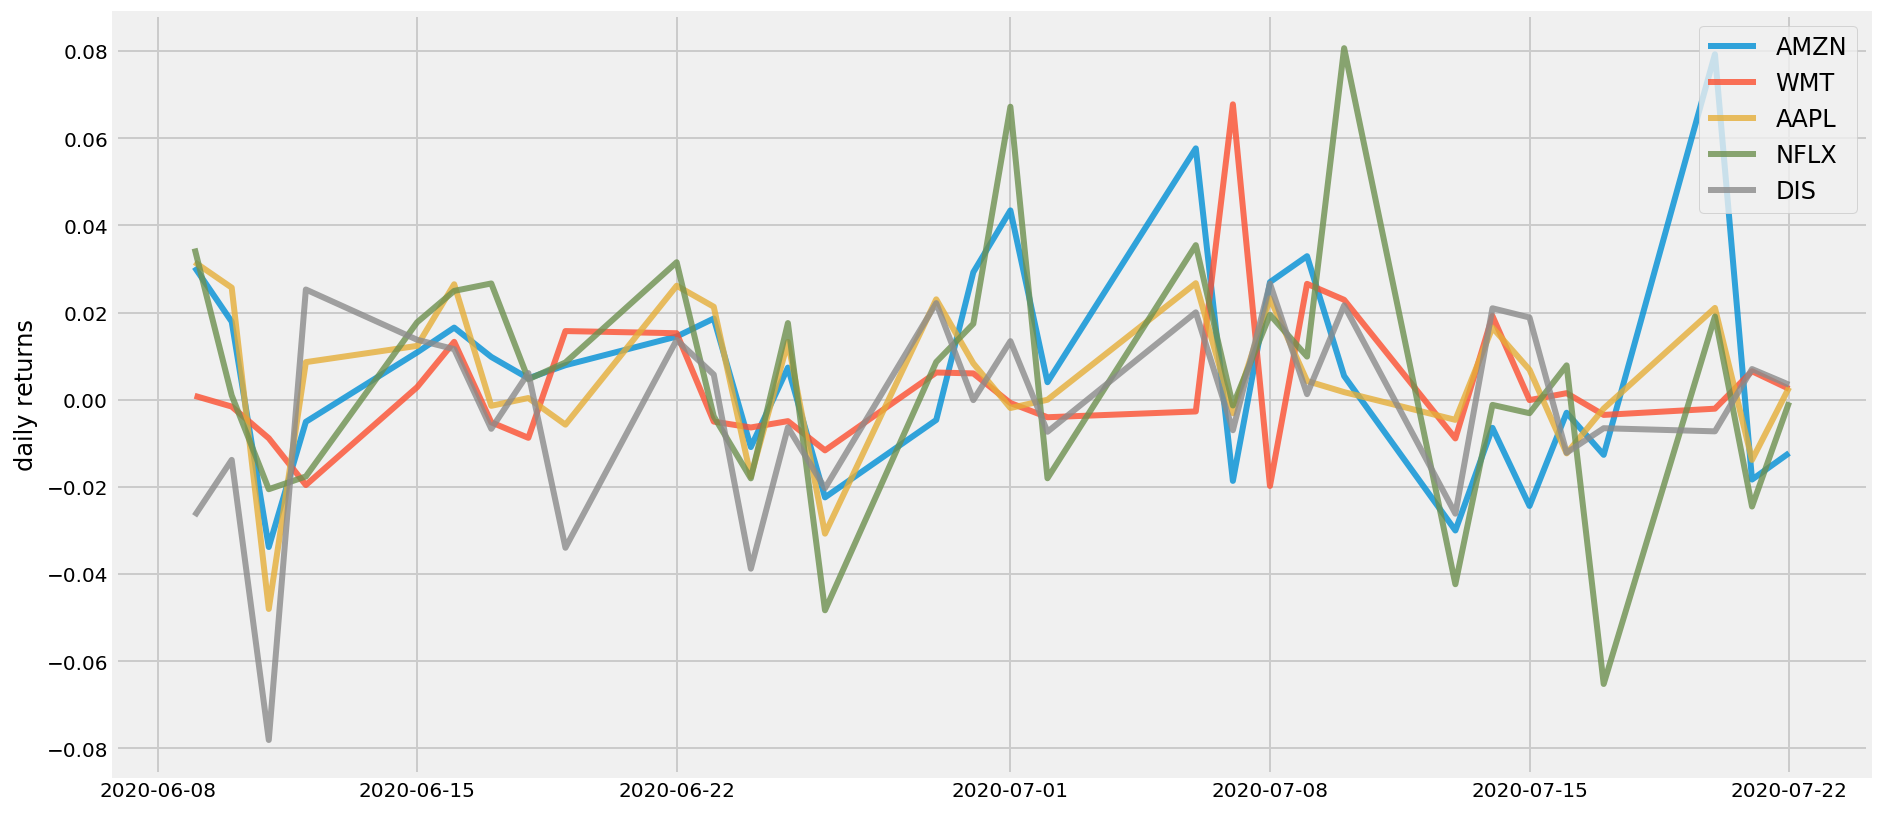

In [5]:
returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [6]:
#Random Portfolio Generation

# we'll define functions to assign random weights to each stock in the portfolio, 
# then calculate the portfolio's overall annualized returns and annualized volatility.

#Function to calculate returns, volitality:

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):

    # Given the avg returns, weights of equities calc. the portfolio return
    returns = np.sum(mean_returns*weights ) *252
    
    # Standard deviation of portfolio (using dot product against covariance, weights)
    # 252 trading days
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

# Next, we can create a function to generate random portfolios with random weights assigned to each equity:
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    
    # Initialize array of shape 3 x N to store our results, 
    # where N is the number of portfolios we're going to simulate
    results = np.zeros((3,num_portfolios))
    
    # Array to store the weights of each stock
    weights_record = []
    for i in range(num_portfolios):
        # Randomly assign floats to our 4 stocks
        weights = np.random.random(5)
        # Convert the randomized floats to percentages (summing to 100)
        weights /= np.sum(weights)
        # Add to our portfolio weight array
        weights_record.append(weights)
        
        # Pull the standard deviation, returns from our function above using the weights, mean returns generated in this function
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        # Store output
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        # Sharpe ratio
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [7]:
#Next, let's set up our final input variables, calculating the mean returns of each stock, as well as a covariance matrix to be used in our risk calculation below.

returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Number of portfolios to simulate
num_portfolios = 25000

# Risk free rate (used for Sharpe ratio below)
risk_free_rate = 0.0178

In [8]:
# Simulating portfolio returns/variance, visualizing the efficient frontier

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    
    # pull results, weights from random portfolios
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    # pull the max portfolio Sharpe ratio (3rd element in results array from 
    # generate_random_portfolios function)
    max_sharpe_idx = np.argmax(results[2])
    
    # pull the associated standard deviation, annualized return w/ the max Sharpe ratio
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    
    # pull the allocation associated with max Sharpe ratio
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    # pull the min vol portfolio Sharpe ratio (1st element in results array from 
    min_vol_idx = np.argmin(results[0])
    
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    

    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    
    # x = volatility, y = annualized return, color mapping = sharpe ratio
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    
    # x = volatility, y = annualized return, color mapping = sharpe ratio
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 1.16
Annualised Volatility: 0.21


Symbols      AMZN    WMT   AAPL  NFLX   DIS
allocation  25.66  45.86  28.15  0.02  0.31
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.96
Annualised Volatility: 0.2


Symbols      AMZN    WMT   AAPL  NFLX   DIS
allocation  11.39  59.34  24.92  0.27  4.09


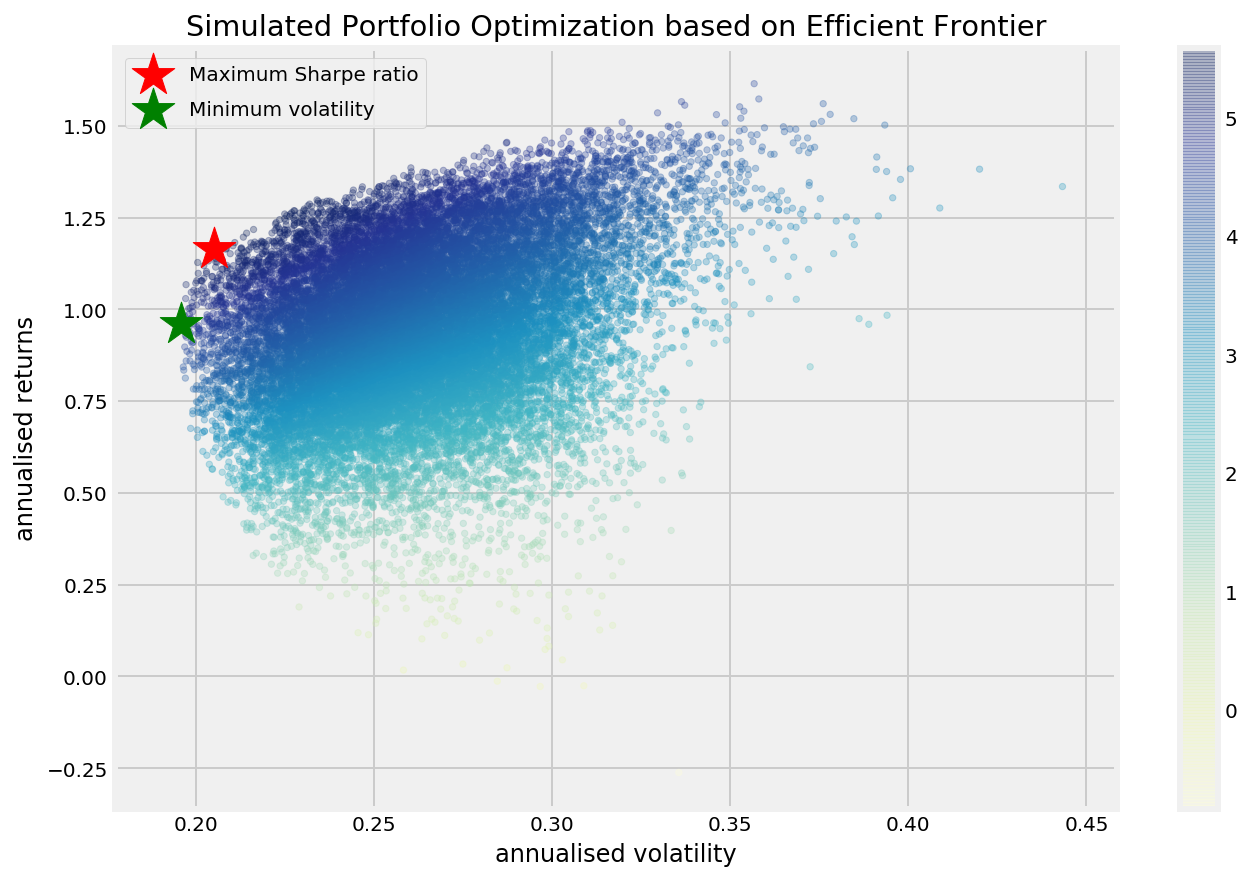

In [9]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# Implication:
here we can seein the table      Symbols     AMZN   WMT  AAPL  NFLX    DIS                                                                   
                               allocation  6.23  62.5   9.1   0.2  21.97                                                     
    at the 16% return rate we are getting about 17 percent return at minimum volitility but if we look at figure 
1 and sharpe ratio table        Symbols     AMZN   WMT  AAPL  NFLX    DIS
                                 allocation  6.23  62.5   9.1   0.2  21
    we can see amazon have better return if we allocate weight according to maximum sharpe ratio by that at risk level of 
about 23% we can increce of return to 33 percent


# Minimum Volatility:
Minimum Volatility (commonly used as "min vol") is a method to reduce the exposure to stock market volaility by tracking
indexes that helps to provide laternatives with lower risk. Min vol doesnot eliminate the loss in the even of a downturn however 
it can surely help to minimize the potential losses compared to other investments.Hence it can be used to lower the portfolio risks.
This method related to low volatility investing, which means investing is an investment style that buy 
securities with low volatility and avoids securities with high volatility